In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import custom_module as cm

In [4]:
# Loading the dataset
data = pd.read_csv("combined_energy.csv", parse_dates=True)

In [6]:
# Setting the format of dataset #
# We're only working with South Australia Region #

# Converting date to datetime object
data["SETTLEMENTDATE"] = pd.to_datetime(data["SETTLEMENTDATE"])

# Seperating data for each region
dataSA = data[data["REGIONID"] == "SA1"]

# Setting Index to Date
dataSA = dataSA[["SETTLEMENTDATE","RRP5min"]]
dataSA.index = dataSA["SETTLEMENTDATE"]
dataSA.drop(columns="SETTLEMENTDATE", inplace=True)

In [7]:
# The Real Test Data Set To Test Later #
X_test = dataSA["2010-01-01":"2010-06-28"]

In [8]:
# replace outliers by outlier threshold
dataSA = cm.replace_outliers(dataSA, 'RRP5min', 3)

In [9]:
# Scaling the RRP between 0 and 1 as required by the NN
scaler = MinMaxScaler()
dataSA["RRP5min"] = scaler.fit_transform(dataSA["RRP5min"].values.reshape(-1,1))

In [10]:
# include time lags of timeseries data for 3 days = 864
# We will use 3 days data to identify patterns to predict the next day
train = dataSA.copy()
lags = 864
for i in range(1,lags+1):
    train["l_{}".format(i)] = train["RRP5min"].shift(i)

In [11]:
# Drop NANS
train.dropna(inplace=True)
train.tail(5)

,RRP5min,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,...,l_855,l_856,l_857,l_858,l_859,l_860,l_861,l_862,l_863,l_864
SETTLEMENTDATE,,,,,,,,,,,,,,,,,,,,,
2010-06-29 03:50:00,0.415018,0.413654,0.413335,0.415335,0.414501,0.415743,0.417310,0.418627,0.419311,0.420692,...,0.421767,0.398850,0.391744,0.418383,0.392728,0.392909,0.422703,0.428359,0.427044,0.427895
2010-06-29 03:55:00,0.411660,0.415018,0.413654,0.413335,0.415335,0.414501,0.415743,0.417310,0.418627,0.419311,...,0.395946,0.421767,0.398850,0.391744,0.418383,0.392728,0.392909,0.422703,0.428359,0.427044
2010-06-29 04:00:00,0.414355,0.411660,0.415018,0.413654,0.413335,0.415335,0.414501,0.415743,0.417310,0.418627,...,0.420954,0.395946,0.421767,0.398850,0.391744,0.418383,0.392728,0.392909,0.422703,0.428359
2010-06-29 04:05:00,0.411693,0.414355,0.411660,0.415018,0.413654,0.413335,0.415335,0.414501,0.415743,0.417310,...,0.420914,0.420954,0.395946,0.421767,0.398850,0.391744,0.418383,0.392728,0.392909,0.422703
2010-06-29 04:10:00,0.374244,0.411693,0.414355,0.411660,0.415018,0.413654,0.413335,0.415335,0.414501,0.415743,...,0.392414,0.420914,0.420954,0.395946,0.421767,0.398850,0.391744,0.418383,0.392728,0.392909


In [12]:
# create feature and label dataframes
prelim_features = train.drop(['RRP5min'], axis=1)
prelim_labels = pd.DataFrame(train[['RRP5min']])


In [13]:
# format labels to 24 hour output range
for i in range(0, 288):
    prelim_labels['t_{}'.format(i)] = prelim_labels['RRP5min'].shift(-i)
prelim_labels.drop(['RRP5min'], axis=1, inplace=True)

# apply one-day discretization to the data
labels = prelim_labels[prelim_labels.index.minute == 0]
labels = labels[labels.index.hour == 0]
features = prelim_features[prelim_features.index.minute == 0]
features = features[features.index.hour == 0]

features_train = features[:'2009']
features_test = features['2010':'2010-06-28']
labels_train = labels[:'2009']

samples_train = len(features_train)
samples_test = len(features_test)
timesteps = 864

# convert pandas data frames to numpy ndarrays
features_train = features_train.to_numpy().reshape(samples_train, timesteps, 1)
features_test = features_test.to_numpy().reshape(samples_test, timesteps, 1)
labels_train = labels_train.to_numpy()

# check for correct data shape
features_train.shape, labels_train.shape

((546, 864, 1), (546, 288))

In [14]:
from keras.models import Model, load_model
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import json

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [21]:
# split into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(features_train, labels_train, test_size=0.2, random_state=7)

In [80]:
###################### DESIGNING THE NN ###################
##########################################################
## 1D Convolution layer to avoid overfitting
## 3 layers of LSTM considering the complexity of the dataset

# Initialising
rnn = Sequential()
# Adding Conv1D Layer
rnn.add(Conv1D(64, kernel_size=288, strides=288, padding='valid', input_shape=(X_train.shape[1],1)))
# Add LSTM layer 1st
rnn.add(LSTM(50, recurrent_activation='relu', return_sequences=True))
rnn.add(Dropout(0.1))
# Add LSTM layer 2nd
rnn.add(LSTM(50, recurrent_activation='relu'))
rnn.add(Dropout(0.1))
rnn.add(Dense(units=288))
rnn.compile(optimizer='adam', loss='mse')

In [81]:
# train the model and calculate the performance on the test set
results, hist = cm.train_predict_evaluate(rnn, X_train, X_valid, y_train, y_valid, features_test,
                                       X_test.to_numpy().flatten(), X_test.index, scaler, 32, 200, 
                                       'simple_neural_network.hdf5', verbose=1)

Epoch 1/200
14/14 [==============================] - 1s 44ms/step - loss: 0.2844 - val_loss: 0.2718
Epoch 2/200
14/14 [==============================] - 0s 20ms/step - loss: 0.2702 - val_loss: 0.2581
Epoch 3/200
14/14 [==============================] - 0s 19ms/step - loss: 0.2566 - val_loss: 0.2448
Epoch 4/200
14/14 [==============================] - 0s 17ms/step - loss: 0.2434 - val_loss: 0.2321
Epoch 5/200
14/14 [==============================] - 0s 20ms/step - loss: 0.2309 - val_loss: 0.2199
Epoch 6/200
14/14 [==============================] - 0s 20ms/step - loss: 0.2130 - val_loss: 0.1649
Epoch 7/200
14/14 [==============================] - 0s 22ms/step - loss: 0.1066 - val_loss: 0.0329
Epoch 8/200
14/14 [==============================] - 0s 20ms/step - loss: 0.0330 - val_loss: 0.0135
Epoch 9/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0223 - val_loss: 0.0171
Epoch 10/200
14/14 [==============================] - 0s 20ms/step - loss: 0.0194 - val_loss: 0.0106

14/14 [==============================] - 0s 15ms/step - loss: 0.0068 - val_loss: 0.0075
Epoch 163/200
14/14 [==============================] - 0s 14ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 164/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 165/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0071 - val_loss: 0.0079
Epoch 166/200
14/14 [==============================] - 0s 15ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 167/200
14/14 [==============================] - 0s 14ms/step - loss: 0.0072 - val_loss: 0.0076
Epoch 168/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 169/200
14/14 [==============================] - 0s 15ms/step - loss: 0.0070 - val_loss: 0.0080
Epoch 170/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 171/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0080 - val_loss: 0

ValueError: Shape of passed values is (82368, 2), indices imply (41184, 2)

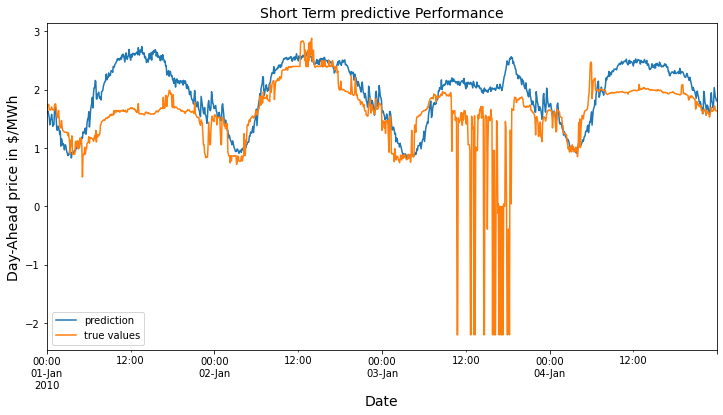

In [20]:
f, ax = plt.subplots(figsize=(12, 6))
results.loc['2010-01-01':'2010-01-04'].plot(ax=ax);
ax.set_ylabel('Day-Ahead price in $/MWh', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Short Term predictive Performance', fontsize=14);

In [21]:
# Quantifying errors
cm.quantify_performance(results)

MAE:  0.4871455835875328
MAE:  0.5279428869633177
MAE:  0.7265967843056544


In [15]:
features_test.shape

(143, 864, 1)